<a href="https://colab.research.google.com/github/Jemi-code/Aperture-synthesis-learning/blob/main/Correlation_H1_simulated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

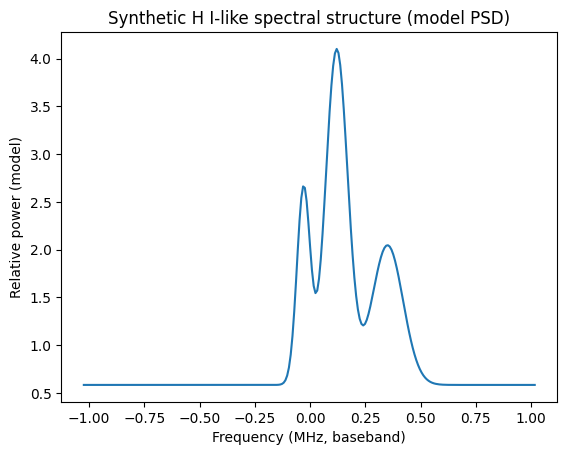

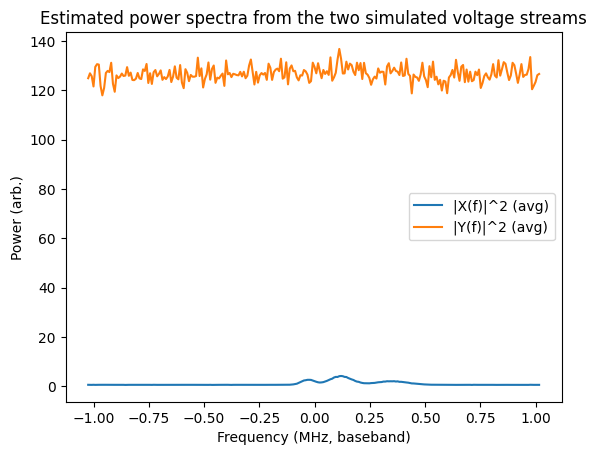

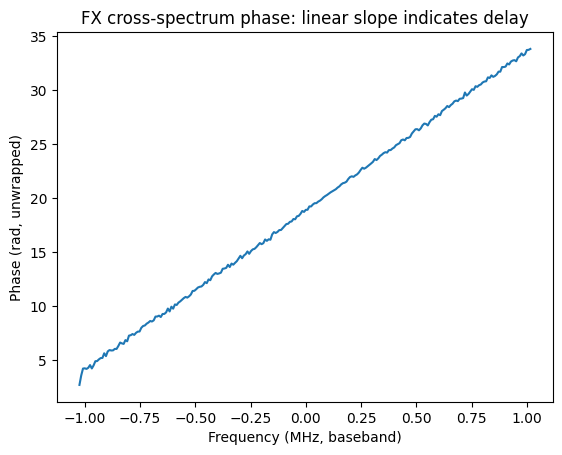

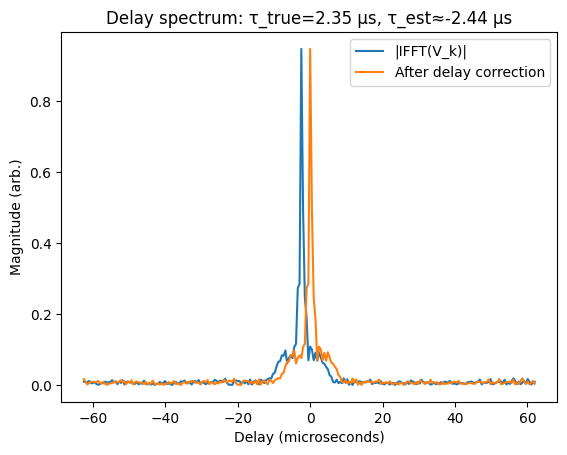

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fftfreq, fftshift

# -----------------------------
# Parameters (TTRT-like)
# -----------------------------
fs = 2.048e6          # sample rate [Hz]
nchan = 256           # number of channels
frame_len = nchan     # FFT length per FX frame
n_frames = 6000       # number of frames to average (controls SNR)
N = frame_len * n_frames

rng = np.random.default_rng(2)

# -----------------------------
# Build a synthetic "H I-like" spectrum (power vs frequency)
# -----------------------------
f = fftfreq(frame_len, d=1/fs)  # Hz

def gaussian(x, mu, sigma):
    return np.exp(-0.5*((x-mu)/sigma)**2)

# Place a few "line" components in baseband (Hz)
mu1, mu2, mu3 = 0.12e6, -0.03e6, 0.35e6
sig1, sig2, sig3 = 0.05e6, 0.03e6, 0.07e6

P = 1.0 \
    + 6.0*gaussian(f, mu1, sig1) \
    + 3.5*gaussian(f, mu2, sig2) \
    + 2.5*gaussian(f, mu3, sig3)

P = P / np.mean(P)

# -----------------------------
# Generate complex baseband voltage time series x[n] with that PSD
# (Generate independent spectra per frame and IFFT each frame.)
# -----------------------------
x = np.empty(N, dtype=np.complex128)

for m in range(n_frames):
    Xf = (rng.normal(size=frame_len) + 1j*rng.normal(size=frame_len)) * np.sqrt(P/2.0)
    x[m*frame_len:(m+1)*frame_len] = ifft(Xf)

# -----------------------------
# Create y[n] as a delayed version of x[n] + independent receiver noise
# -----------------------------
tau_sec = 2.35e-6  # true delay [s]
freqs_full = fftfreq(N, d=1/fs)
y_clean = ifft(fft(x) * np.exp(-1j * 2*np.pi * freqs_full * tau_sec))

noise_level = 0.7
y = y_clean + noise_level*(rng.normal(size=N) + 1j*rng.normal(size=N))/np.sqrt(2)

# -----------------------------
# FX correlation: FFT -> multiply -> average (per channel)
# -----------------------------
V_avg = np.zeros(frame_len, dtype=np.complex128)
Xps = np.zeros(frame_len)
Yps = np.zeros(frame_len)

# Use a smaller subset for power spectra display (speed)
n_ps = 2000

for m in range(n_frames):
    xseg = x[m*frame_len:(m+1)*frame_len]
    yseg = y[m*frame_len:(m+1)*frame_len]
    Xk = fft(xseg)
    Yk = fft(yseg)
    V_avg += Xk * np.conj(Yk)
    if m < n_ps:
        Xps += np.abs(Xk)**2
        Yps += np.abs(Yk)**2

V_avg /= n_frames
Xps /= n_ps
Yps /= n_ps

# -----------------------------
# Estimate delay: IFFT across frequency channels
# -----------------------------
delay_spec = fftshift(ifft(V_avg))

# Delay axis: for channel spacing Δf = fs/Nfft, the delay axis is τ = m / fs (up to +/- 1/Δf)
taus = fftshift(fftfreq(frame_len, d=fs/frame_len))  # seconds
taus_us = taus * 1e6

peak_idx = np.argmax(np.abs(delay_spec))
tau_est_us = taus_us[peak_idx]

# Delay correction (rotate phases per channel)
nu_k = fftfreq(frame_len, d=1/fs)  # Hz
V_corr = V_avg * np.exp(+1j * 2*np.pi * nu_k * (tau_est_us*1e-6))
delay_spec_corr = fftshift(ifft(V_corr))

# -----------------------------
# Visualizations
# -----------------------------
plt.figure()
plt.plot(fftshift(f)/1e6, fftshift(P))
plt.xlabel("Frequency (MHz, baseband)")
plt.ylabel("Relative power (model)")
plt.title("Synthetic H I-like spectral structure (model PSD)")

plt.figure()
plt.plot(fftshift(f)/1e6, fftshift(Xps), label="|X(f)|^2 (avg)")
plt.plot(fftshift(f)/1e6, fftshift(Yps), label="|Y(f)|^2 (avg)")
plt.xlabel("Frequency (MHz, baseband)")
plt.ylabel("Power (arb.)")
plt.title("Estimated power spectra from the two simulated voltage streams")
plt.legend()

phase = np.unwrap(np.angle(fftshift(V_avg)))
plt.figure()
plt.plot(fftshift(f)/1e6, phase)
plt.xlabel("Frequency (MHz, baseband)")
plt.ylabel("Phase (rad, unwrapped)")
plt.title("FX cross-spectrum phase: linear slope indicates delay")

plt.figure()
plt.plot(taus_us, np.abs(delay_spec), label="|IFFT(V_k)|")
plt.plot(taus_us, np.abs(delay_spec_corr), label="After delay correction")
plt.xlabel("Delay (microseconds)")
plt.ylabel("Magnitude (arb.)")
plt.title(f"Delay spectrum: τ_true={tau_sec*1e6:.2f} µs, τ_est≈{tau_est_us:.2f} µs")
plt.legend()

plt.show()

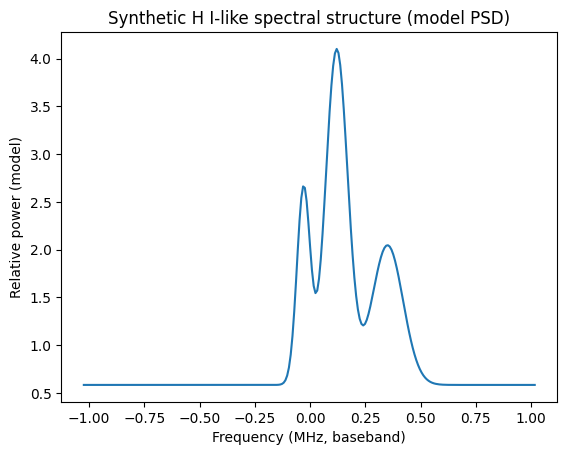

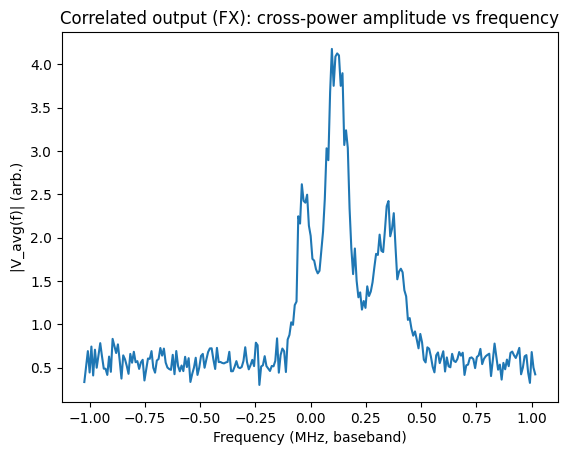

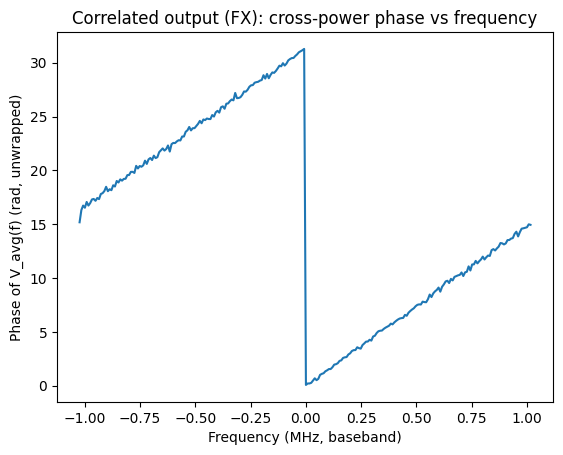

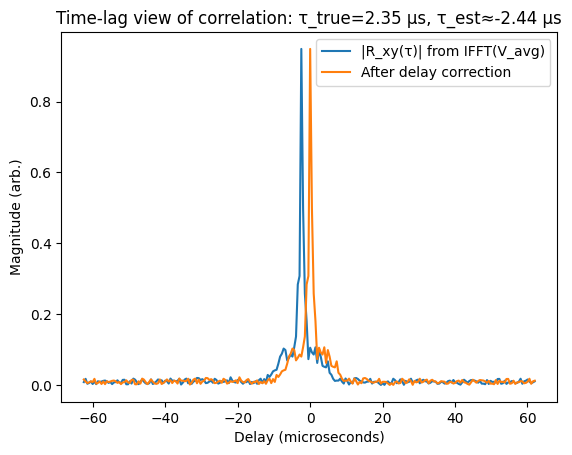

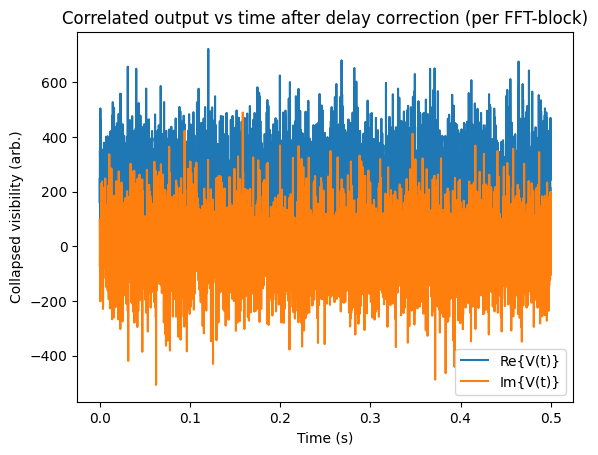

np.float64(-2.44140625)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fftfreq, fftshift

# -----------------------------
# Parameters (TTRT-like)
# -----------------------------
fs = 2.048e6          # sample rate [Hz]
nchan = 256           # number of channels
frame_len = nchan     # FFT length per FX frame
n_frames = 4000       # reduced for speed
N = frame_len * n_frames

rng = np.random.default_rng(2)

# -----------------------------
# Build a synthetic "H I-like" spectrum (power vs frequency)
# -----------------------------
f = fftfreq(frame_len, d=1/fs)  # Hz

def gaussian(x, mu, sigma):
    return np.exp(-0.5*((x-mu)/sigma)**2)

mu1, mu2, mu3 = 0.12e6, -0.03e6, 0.35e6
sig1, sig2, sig3 = 0.05e6, 0.03e6, 0.07e6

P = 1.0 + 6.0*gaussian(f, mu1, sig1) + 3.5*gaussian(f, mu2, sig2) + 2.5*gaussian(f, mu3, sig3)
P = P / np.mean(P)

# -----------------------------
# Generate complex baseband voltage time series x[n] with that PSD
# -----------------------------
x = np.empty(N, dtype=np.complex128)
for m in range(n_frames):
    Xf = (rng.normal(size=frame_len) + 1j*rng.normal(size=frame_len)) * np.sqrt(P/2.0)
    x[m*frame_len:(m+1)*frame_len] = ifft(Xf)

# -----------------------------
# Create y[n] as delayed x[n] + independent noise
# -----------------------------
tau_sec = 2.35e-6  # true delay [s]
freqs_full = fftfreq(N, d=1/fs)
y_clean = ifft(fft(x) * np.exp(-1j * 2*np.pi * freqs_full * tau_sec))

noise_level = 0.7
y = y_clean + noise_level*(rng.normal(size=N) + 1j*rng.normal(size=N))/np.sqrt(2)

# -----------------------------
# FX correlation: FFT -> multiply -> average (per channel)
# -----------------------------
V_avg = np.zeros(frame_len, dtype=np.complex128)
for m in range(n_frames):
    xseg = x[m*frame_len:(m+1)*frame_len]
    yseg = y[m*frame_len:(m+1)*frame_len]
    Xk = fft(xseg)
    Yk = fft(yseg)
    V_avg += Xk * np.conj(Yk)
V_avg /= n_frames

# "Correlated signal" view #1: Cross-power spectrum V_avg(k)
V_amp = np.abs(V_avg)
V_phase = np.unwrap(np.angle(V_avg))

# "Correlated signal" view #2: Cross-correlation vs delay
delay_spec = fftshift(ifft(V_avg))
taus = fftshift(fftfreq(frame_len, d=fs/frame_len))  # seconds
taus_us = taus * 1e6
peak_idx = np.argmax(np.abs(delay_spec))
tau_est_us = taus_us[peak_idx]

# Delay correction
nu_k = fftfreq(frame_len, d=1/fs)  # Hz
V_corr = V_avg * np.exp(+1j * 2*np.pi * nu_k * (tau_est_us*1e-6))
delay_spec_corr = fftshift(ifft(V_corr))

# "Correlated signal" view #3: Coherent visibility time-series (per block)
vis_t = np.zeros(n_frames, dtype=np.complex128)
phase_rot = np.exp(+1j * 2*np.pi * nu_k * (tau_est_us*1e-6))

for m in range(n_frames):
    xseg = x[m*frame_len:(m+1)*frame_len]
    yseg = y[m*frame_len:(m+1)*frame_len]
    Vk = fft(xseg) * np.conj(fft(yseg))
    Vk *= phase_rot
    vis_t[m] = np.sum(Vk)

t_sec = (np.arange(n_frames) * frame_len) / fs

# -----------------------------
# Plots
# -----------------------------
plt.figure()
plt.plot(fftshift(f)/1e6, fftshift(P))
plt.xlabel("Frequency (MHz, baseband)")
plt.ylabel("Relative power (model)")
plt.title("Synthetic H I-like spectral structure (model PSD)")

plt.figure()
plt.plot(fftshift(f)/1e6, fftshift(V_amp))
plt.xlabel("Frequency (MHz, baseband)")
plt.ylabel("|V_avg(f)| (arb.)")
plt.title("Correlated output (FX): cross-power amplitude vs frequency")

plt.figure()
plt.plot(fftshift(f)/1e6, fftshift(V_phase))
plt.xlabel("Frequency (MHz, baseband)")
plt.ylabel("Phase of V_avg(f) (rad, unwrapped)")
plt.title("Correlated output (FX): cross-power phase vs frequency")

plt.figure()
plt.plot(taus_us, np.abs(delay_spec), label="|R_xy(τ)| from IFFT(V_avg)")
plt.plot(taus_us, np.abs(delay_spec_corr), label="After delay correction")
plt.xlabel("Delay (microseconds)")
plt.ylabel("Magnitude (arb.)")
plt.title(f"Time-lag view of correlation: τ_true={tau_sec*1e6:.2f} µs, τ_est≈{tau_est_us:.2f} µs")
plt.legend()

plt.figure()
show_sec = 2.0
mask = t_sec <= show_sec
plt.plot(t_sec[mask], np.real(vis_t[mask]), label="Re{V(t)}")
plt.plot(t_sec[mask], np.imag(vis_t[mask]), label="Im{V(t)}")
plt.xlabel("Time (s)")
plt.ylabel("Collapsed visibility (arb.)")
plt.title("Correlated output vs time after delay correction (per FFT-block)")
plt.legend()

plt.show()

tau_est_us

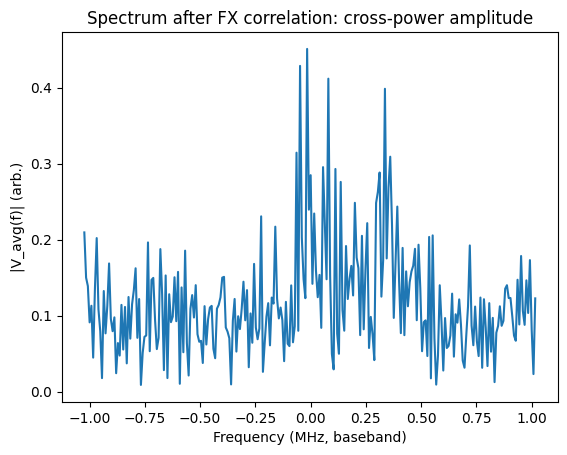

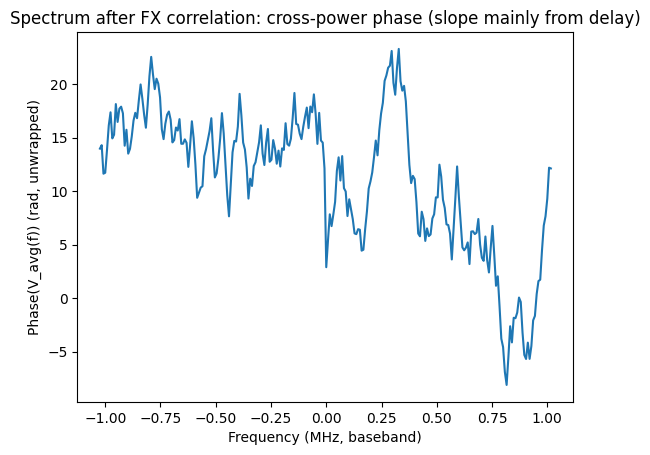

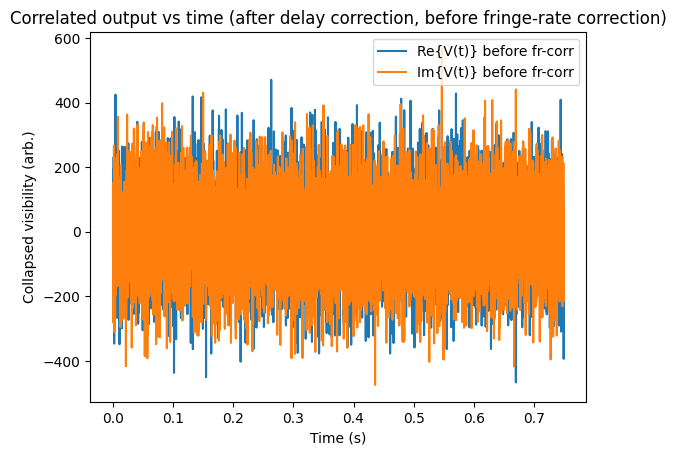

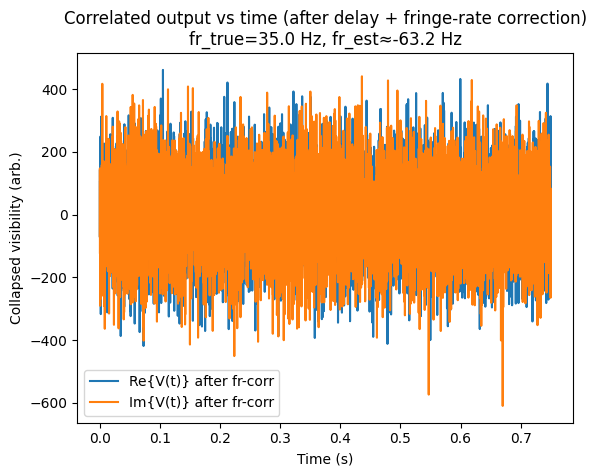

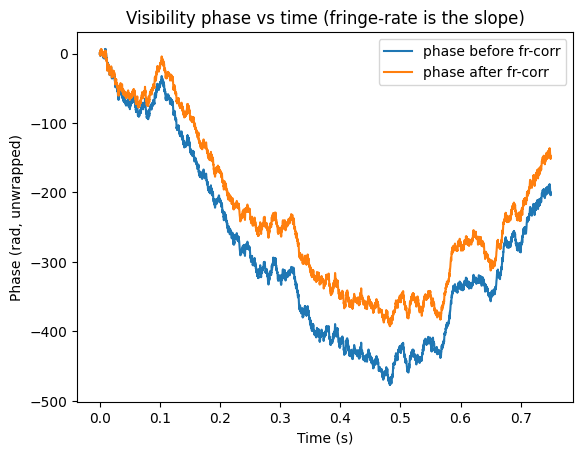

(2.35,
 np.float64(-23.4375),
 35.0,
 np.float64(-63.164382056511755),
 np.complex128(2.092368217884701-1.9637878481026128j))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fftfreq, fftshift

# -----------------------------
# Parameters (TTRT-like)
# -----------------------------
fs = 2.048e6          # sample rate [Hz]
nchan = 256           # number of channels
Nfft = nchan          # FX FFT length (channels)
n_frames = 6000       # number of FX frames (time blocks)
N = Nfft * n_frames

rng = np.random.default_rng(2)

# -----------------------------
# Synthetic H I-like spectrum (power vs frequency)
# -----------------------------
f = fftfreq(Nfft, d=1/fs)  # Hz

def gaussian(x, mu, sigma):
    return np.exp(-0.5*((x-mu)/sigma)**2)

# Multi-component line structure (baseband Hz)
mu1, mu2, mu3 = 0.12e6, -0.03e6, 0.35e6
sig1, sig2, sig3 = 0.05e6, 0.03e6, 0.07e6

P = 1.0 + 6.0*gaussian(f, mu1, sig1) + 3.5*gaussian(f, mu2, sig2) + 2.5*gaussian(f, mu3, sig3)
P = P / np.mean(P)

# -----------------------------
# Generate complex baseband voltage time series x[n] with that PSD
# (Independent spectra per frame -> IFFT)
# -----------------------------
x = np.empty(N, dtype=np.complex128)
for m in range(n_frames):
    Xf = (rng.normal(size=Nfft) + 1j*rng.normal(size=Nfft)) * np.sqrt(P/2.0)
    x[m*Nfft:(m+1)*Nfft] = ifft(Xf)

# -----------------------------
# Create y[n] as delayed x[n] + independent noise + a small clock/LO mismatch
# -----------------------------
tau_true = 2.35e-6  # true delay [s]

# fractional delay via phase ramp in frequency domain (whole stream)
freqs_full = fftfreq(N, d=1/fs)
y_clean = ifft(fft(x) * np.exp(-1j * 2*np.pi * freqs_full * tau_true))

# Add a small residual "fringe rate" (models independent clocks/LOs)
# (phase rotation per sample)
fr_true = 35.0  # Hz (fringe rate), chosen for easy visualization
n = np.arange(N)
y_clean *= np.exp(1j * 2*np.pi * fr_true * (n/fs))

# Add independent complex receiver noise
noise_level = 0.7
y = y_clean + noise_level*(rng.normal(size=N) + 1j*rng.normal(size=N))/np.sqrt(2)

# -----------------------------
# FX correlation: per frame FFT -> cross-multiply -> average cross-spectrum
# Also keep per-frame visibilities for "V(t)"
# -----------------------------
V_avg = np.zeros(Nfft, dtype=np.complex128)
V_frames = np.zeros((n_frames, Nfft), dtype=np.complex128)

for m in range(n_frames):
    xs = x[m*Nfft:(m+1)*Nfft]
    ys = y[m*Nfft:(m+1)*Nfft]
    Xk = fft(xs)
    Yk = fft(ys)
    Vk = Xk * np.conj(Yk)
    V_frames[m] = Vk
    V_avg += Vk

V_avg /= n_frames

# -----------------------------
# Estimate delay from averaged cross-spectrum using IFFT across frequency
# -----------------------------
delay_spec = fftshift(ifft(V_avg))
taus = fftshift(fftfreq(Nfft, d=fs/Nfft))  # seconds
taus_us = taus * 1e6

peak_idx = np.argmax(np.abs(delay_spec))
tau_est = taus[peak_idx]  # seconds

# Delay correction: rotate phases per channel
nu_k = fftfreq(Nfft, d=1/fs)  # Hz
delay_rot = np.exp(+1j * 2*np.pi * nu_k * tau_est)

# Apply delay correction to each time frame and collapse to a single complex V(t)
Vt = np.zeros(n_frames, dtype=np.complex128)
for m in range(n_frames):
    Vk = V_frames[m] * delay_rot
    Vt[m] = np.sum(Vk)  # collapse across channels (simple sum)

t_sec = (np.arange(n_frames) * Nfft) / fs  # time stamp per FX frame

# -----------------------------
# Fringe-rate estimate from V(t): unwrap phase vs time and fit a line
# -----------------------------
phi = np.unwrap(np.angle(Vt))
A = np.vstack([t_sec, np.ones_like(t_sec)]).T
slope, intercept = np.linalg.lstsq(A, phi, rcond=None)[0]
fr_est = slope / (2*np.pi)  # Hz

# Fringe-rate correction
Vt_corr = Vt * np.exp(-1j * 2*np.pi * fr_est * t_sec)

# Also compute a "coherently averaged" visibility over time after correction
V_coh = np.mean(Vt_corr)

# -----------------------------
# PLOTS: 1) Spectrum after correlation  2) Correlated output vs time
# -----------------------------
# --- Spectrum after correlation: amplitude and phase vs frequency ---
plt.figure()
plt.plot(fftshift(f)/1e6, fftshift(np.abs(V_avg)))
plt.xlabel("Frequency (MHz, baseband)")
plt.ylabel("|V_avg(f)| (arb.)")
plt.title("Spectrum after FX correlation: cross-power amplitude")

plt.figure()
plt.plot(fftshift(f)/1e6, fftshift(np.unwrap(np.angle(V_avg))))
plt.xlabel("Frequency (MHz, baseband)")
plt.ylabel("Phase(V_avg(f)) (rad, unwrapped)")
plt.title("Spectrum after FX correlation: cross-power phase (slope mainly from delay)")

# --- Correlated output vs time (before and after fringe-rate correction) ---
plt.figure()
show_sec = 1.0
mask = t_sec <= show_sec
plt.plot(t_sec[mask], np.real(Vt[mask]), label="Re{V(t)} before fr-corr")
plt.plot(t_sec[mask], np.imag(Vt[mask]), label="Im{V(t)} before fr-corr")
plt.xlabel("Time (s)")
plt.ylabel("Collapsed visibility (arb.)")
plt.title("Correlated output vs time (after delay correction, before fringe-rate correction)")
plt.legend()

plt.figure()
plt.plot(t_sec[mask], np.real(Vt_corr[mask]), label="Re{V(t)} after fr-corr")
plt.plot(t_sec[mask], np.imag(Vt_corr[mask]), label="Im{V(t)} after fr-corr")
plt.xlabel("Time (s)")
plt.ylabel("Collapsed visibility (arb.)")
plt.title(f"Correlated output vs time (after delay + fringe-rate correction)\nfr_true={fr_true:.1f} Hz, fr_est≈{fr_est:.1f} Hz")
plt.legend()

# --- Show how coherence improves: phase scatter before/after ---
plt.figure()
plt.plot(t_sec[mask], np.unwrap(np.angle(Vt[mask])), label="phase before fr-corr")
plt.plot(t_sec[mask], np.unwrap(np.angle(Vt_corr[mask])), label="phase after fr-corr")
plt.xlabel("Time (s)")
plt.ylabel("Phase (rad, unwrapped)")
plt.title("Visibility phase vs time (fringe-rate is the slope)")
plt.legend()

plt.show()

tau_true*1e6, tau_est*1e6, fr_true, fr_est, V_coh
